# **Módulo 3: Introducción a *deep learning* con PyTorch**

## Introducción

En cuadernos anteriores, hemos creado, entrenado y evaluado redes neuronales con las clases de Python que hemos desarrollado. Existen muchas librerías de código abierto que ayudan a optimizar el proceso de creación de estos modelos y a hacerlo replicable. En este cuaderno, vamos a conocer una de las más populares: PyTorch.

Ahora que conocemos los fundamentos del uso de tensores en [Pytorch](https://pytorch.org/), vamos a utilizarlos para crear modelos de *deep learning*. En el siguiente cuaderno, veremos cómo crear modelos de clasificación y regresión con esta librería y aplicarlos a un gran conjunto de datos público.

## Clasificación con PyTorch

En este primer ejemplo, utilizaremos PyTorch para realizar una tarea de clasificación binaria con un conjunto de datos de código abierto. El conjunto de datos, que se puede encontrar [aquí](https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/), contiene información sobre la edad de los abalones.

Los [abalones](https://es.wikipedia.org/wiki/Haliotis) son un tipo de molusco cuya edad se puede determinar contando manualmente los anillos del interior de su caparazón. Este conjunto de datos contiene una serie de medidas que sirven para predecir el número de anillos.

### Descargar el conjunto de datos e importar el módulo

In [1]:
# Descargar los archivos .csv sobre abalones del repositorio si fuera necesario
!rm abalone.data abalone.names
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.names

--2022-12-27 20:40:19--  https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 191873 (187K) [application/x-httpd-php]
Saving to: ‘abalone.data’

abalone.data        100%[===================>] 187,38K   183KB/s    in 1,0s    

2022-12-27 20:40:25 (183 KB/s) - ‘abalone.data’ saved [191873/191873]

--2022-12-27 20:40:26--  https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.names
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4319 (4,2K) [application/x-httpd-php]
Saving to: ‘abalone.names’

abalone.names       100%[===================>]   4,22K  --.-KB/s    in 0s   

In [2]:
# Ahora vamos a necesitar muchos módulos diferentes
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from torch.utils.data import TensorDataset, DataLoader 

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time, copy

### Preparar los datos sobre los abalones para la clasificación

Queremos crear un problema de clasificación para diferenciar entre abalones jóvenes y viejos. Consideramos joven a cualquiera que tenga menos de 10 anillos y viejos a los que tengan más.

In [3]:

column_names = ["Sex", "Length", "Diameter", "Height", "Whole weight", 
                "Shucked weight", "Viscera weight", "Shell weights", "Rings"]
df = pd.read_csv('abalone.data', header=None, names=column_names)
df['Old'] = 0  # Por defecto, todos los abalones se clasifican como jóvenes
df.loc[(df['Rings'] >= 10), 'Old'] = 1 # 10 anillos o más implican que un abalón es viejo
class_labels = ['Young', 'Old']   # [0, 1], [N, P]
numerical_feature_columns = column_names[1:5] # Primero, nos interesa clasificarlos mediante atributos numéricos, excluyendo el sexo. De entre los atributos numéricos, solo el peso total
print(numerical_feature_columns)
label_column = 'Old'


df.head() # Visualizar un subconjunto del conjunto total

['Length', 'Diameter', 'Height', 'Whole weight']


,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weights,Rings,Old
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,1
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,0
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,1
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0


### División entrenamiento/validación/prueba y estandarización

Para esta tarea de clasificación, vamos a dividir el conjunto de datos en 3 subconjuntos diferentes, como se describe en el módulo. El subconjunto de entrenamiento será el más grande, y es el que utilizaremos para entrenar y optimizar los pesos del modelo. El siguiente será el subconjunto de validación, que servirá para evaluar de forma no sesgada el modelo y ayudar a afinar los distintos hiperparámetros. El último será el subconjunto de prueba, que servirá para evaluar de forma no sesgada el modelo totalmente entrenado.

Además, realizaremos una estandarización de los datos eliminando la media y escalando mediante la varianza. Haremos esto con cada uno de los atributos, pero queremos garantizar que esta función de estandarización se compute en el subconjunto de datos de entrenamiento. Después, aplicamos la función de estandairzación a los subconjuntos de validación y prueba. Al garantizar que la estandarización solo se compute en el subconjunto de entrenamiento, nos aseguramos de que no se filtre información de los otros dos subconjuntos.

Más abajo, incluimos una función para dividir un conjunto de datos en tres subconjuntos de entrenamiento, validación y prueba con una proporción de 60-20-20 y estandarizar los datos con la clase StandardScaler de Sklearn para poder usarlos con Python:

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


def train_test_val_split(df, feature_columns, label_column, ct):
    # Primero, realizar una división 80/20 en entrenamiento y prueba
    seed = 42
    initial_train_split = df.sample(frac=.8, random_state = seed)
    test = df.drop(initial_train_split.index)   # remover todo este subset del dataset original
    # test = 20%
    # init = 80%

    # A continuación, realizar una división 75/25 entre entrenamiento y validación
    train = initial_train_split.sample(frac=.75, random_state = seed)
    val = initial_train_split.drop(train.index)
    # val   = 25%
    # train = 75%

    # Dividir todos los subconjuntos en atributos y etiquetas (x e y)
    train_x = train[feature_columns]
    # No transformaremos las etiquetas para que vayan directamente a los tensores torch
    train_y = torch.from_numpy(train[label_column].values)

    val_x = val[feature_columns]
    val_y = torch.from_numpy(val[label_column].values)

    test_x = test[feature_columns]
    test_y = torch.from_numpy(test[label_column].values)

    # Ajustar ColumnTransfer al conjunto de entrenamiento
    ct.fit(train_x)

    # Realizar la estandarización con cada uno de los conjuntos de datos x
    train_x = ct.transform(train_x)
    val_x = ct.transform(val_x)
    test_x = ct.transform(test_x)

    # Convertir los conjuntos de datos en tensores Torch
    train_x = torch.from_numpy(train_x).float()
    val_x = torch.from_numpy(val_x).float()
    test_x = torch.from_numpy(test_x).float()

    # Crear los conjuntos de datos de pares input-etiqueta para que PyTorch los consuma
    train_dataset = TensorDataset(train_x, train_y)
    test_dataset = TensorDataset(test_x, test_y)
    val_dataset = TensorDataset(val_x, val_y)
    return train_dataset, test_dataset, val_dataset


In [5]:
# Crear StandardScaler para la estandarización de datos
# Más información aquí: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
# https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer
ct = ColumnTransformer([('numerical_features', StandardScaler(), numerical_feature_columns)], remainder='passthrough')

train_dataset, test_dataset, val_dataset = train_test_val_split(df, numerical_feature_columns, label_column, ct)

### Hiperparámetros del modelo

Ahora que podemos dividir fácilmente el conjunto de datos en subconjuntos de entrenamiento, validación y prueba, pasamos a seleccionar los hiperparámetros. Estos incluyen decisiones sobre la arquitectura del modelo (como el número de capas ocultas) y parámetros de entrenamiento externos, como el tamaño de los lotes, la tasa de aprendizaje y el número de ciclos de entrenamiento.

In [6]:
# Configuración del dispositivo (si es posible, entrenar el modelo en la GPU, el proceso será mucho más rápido)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print("device:", device)

# Hiperparámetros

# Arquitectura del modelo
input_size = len(numerical_feature_columns) # Asegurar que se ellimina la columna index
hidden_size1 = 64
hidden_size2 = 64
hidden_size3 = 64
num_classes = 2

# Parámetros de entrenamiento externos
batch_size = 10
learning_rate = 0.001
num_epochs = 50


device: cuda


### Selección de hiperparámetros

En este proceso, utilizaremos el conjunto de validación para definir dos hiperparámetros diferentes.

El primero es el número total de ciclos durante los que queremos entrenar el modelo. Al final del proceso de entrenamiento completo, seleccionaremos los pesos del ciclo con la precisión de validación más alta.

 El segundo es el número de capas. Probaremos con redes de 2 y 3 capas ocultas. De nuevo, seleccionaremos el que tenga mejor rendimiento con el conjunto de validación.

In [7]:
# Modelo de clasificación simple de dos capas ocultas
class SimpleClassifier2Layer(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(SimpleClassifier2Layer, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, num_classes),
        )

    def forward(self, x):
        return self.layers(x)

# Modelo de clasificación simple de tres capas ocultas
class SimpleClassifier3Layer(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, num_classes):
        super(SimpleClassifier3Layer, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, hidden_size3),
            nn.ReLU(),
            nn.Linear(hidden_size3, num_classes),
        )

    def forward(self, x):
        return self.layers(x)

In [8]:
two_layer_model = SimpleClassifier2Layer(input_size, hidden_size1, hidden_size2, num_classes).to(device)
print(two_layer_model)

three_layer_model = SimpleClassifier3Layer(input_size, hidden_size1, hidden_size2, hidden_size3, num_classes).to(device)
print(three_layer_model)

SimpleClassifier2Layer(
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)
SimpleClassifier3Layer(
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)


### Preparación final de los datos

Ahora que hemos definido el modelo y los hiperparámetros, podemos pasar a la última fase de la preparación. Utilizaremos una clase de PyTorch llamada "DataLoader" con el tamaño de lote que hemos especificado antes. Esta clase será la responsable de introducir los lotes de datos en el modelo durante el entrenamiento.

In [9]:
dataloaders = {'train': DataLoader(train_dataset, batch_size=batch_size),
               'val': DataLoader(val_dataset, batch_size=batch_size),
               'test': DataLoader(test_dataset, batch_size=batch_size)}

dataset_sizes = {'train': len(train_dataset),
                 'val': len(val_dataset),
                 'test': len(test_dataset)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 2506, 'val': 836, 'test': 835}


### Entrenar al modelo

Ahora que hemos definido el tipo de arquitectura y los datos están listos para trabajar, debemos definir la función de entrenamiento. Esta es responsable de actualizar todos los pesos del modelo.

In [10]:
# Extraído de https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # Los mejores pesos se deben guardar por separado
    best_acc = 0.0
    best_epoch = 0

    # Cada ciclo tiene una fase de entrenamiento, una de validación y una de prueba
    phases = ['train', 'val', 'test']
    
    # Hacer un seguimiento de la evolución de la pérdida y la precisión durante el entrenamiento
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []
        training_curves[phase+'_acc'] = []
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Configurar el modelo en el modo de entrenamiento
            else:
                model.eval()   # Configurar el modelo en el modo de evaluación

            running_loss = 0.0
            running_corrects = 0

            # Iterar con los datos
            for inputs, labels in dataloaders[phase]:
                # Importante: se deben aplanar todos los puntos de datos
                # para que sean compatibles con el modelo
                inputs = inputs.view(inputs.shape[0],-1)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Poner a 0 los gradientes de los parámetros
                optimizer.zero_grad()

                # Método forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, predictions = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Método backward y actualización de los pesos solo si está en la fase de entrenamiento
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Estadísticas
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == labels.data)
 
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)
            training_curves[phase+'_acc'].append(epoch_acc)

            print(f'{phase:5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Hacer una copia profunda del modelo si se ha alcanzado la mejor precisión
            if phase == 'val' and epoch_acc > best_acc:
                best_epoch = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f} at epoch {best_epoch}')

    # Cargar los mejores pesos del modelo
    model.load_state_dict(best_model_wts)
    
    return model, training_curves

Hemos escrito la función de arriba de tal manera que sea independiente de la arquitectura. Eso significa que podemos usar la misma función para entrenar redes tanto la red de dos capas como la de tres capas.

In [11]:
# Entrenamiento con dos capas ocultas
# Pérdida y optimizador
criterion = nn.CrossEntropyLoss() # Aplicar la función de pérdida CrossEntropyLoss para la clasificación
optimizer = torch.optim.Adam(two_layer_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Entrenar el modelo. También guardaremos los resultados del entrenamiento para poder visualizarlos
two_layer_model, training_curves_two_layer = train_model(two_layer_model, dataloaders, dataset_sizes, 
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/50
----------
train Loss: 0.5399 Acc: 0.7338
val   Loss: 0.4651 Acc: 0.7667
test  Loss: 0.5292 Acc: 0.7198

Epoch 2/50
----------
train Loss: 0.5212 Acc: 0.7386
val   Loss: 0.4589 Acc: 0.7691
test  Loss: 0.5257 Acc: 0.7210

Epoch 3/50
----------
train Loss: 0.5169 Acc: 0.7390
val   Loss: 0.4572 Acc: 0.7715
test  Loss: 0.5248 Acc: 0.7281

Epoch 4/50
----------
train Loss: 0.5139 Acc: 0.7406
val   Loss: 0.4568 Acc: 0.7775
test  Loss: 0.5249 Acc: 0.7269

Epoch 5/50
----------
train Loss: 0.5103 Acc: 0.7438
val   Loss: 0.4546 Acc: 0.7787
test  Loss: 0.5245 Acc: 0.7234

Epoch 6/50
----------
train Loss: 0.5082 Acc: 0.7450
val   Loss: 0.4551 Acc: 0.7799
test  Loss: 0.5245 Acc: 0.7186

Epoch 7/50
----------
train Loss: 0.5069 Acc: 0.7462
val   Loss: 0.4548 Acc: 0.7787
test  Loss: 0.5243 Acc: 0.7174

Epoch 8/50
----------
train Loss: 0.5058 Acc: 0.7466
val   Loss: 0.4552 Acc: 0.7823
test  Loss: 0.5243 Acc: 0.7138

Epoch 9/50
----------
train Loss: 0.5045 Acc: 0.7482
val   Loss: 0.4551

Para elegir el peso que utilizaremos en el modelo final, debemos buscar el ciclo que mejor rendimiento ha obtenido al trabajar con el conjunto de validación.

In [12]:
# Entrenamiento con tres capas ocultas
# Pérdida y optimizador
criterion = nn.CrossEntropyLoss() # Aplicar la función de pérdida CrossEntropyLoss para la clasificación
optimizer = torch.optim.Adam(three_layer_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Entrenar el modelo. También guardaremos los resultados del entrenamiento para poder visualizarlos
three_layer_model, training_curves_three_layer = train_model(three_layer_model, dataloaders, dataset_sizes, 
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/50
----------
train Loss: 0.5481 Acc: 0.7342
val   Loss: 0.4662 Acc: 0.7727
test  Loss: 0.5304 Acc: 0.7222

Epoch 2/50
----------
train Loss: 0.5227 Acc: 0.7442
val   Loss: 0.4624 Acc: 0.7871
test  Loss: 0.5284 Acc: 0.7257

Epoch 3/50
----------
train Loss: 0.5173 Acc: 0.7458
val   Loss: 0.4607 Acc: 0.7835
test  Loss: 0.5281 Acc: 0.7222

Epoch 4/50
----------
train Loss: 0.5115 Acc: 0.7494
val   Loss: 0.4578 Acc: 0.7835
test  Loss: 0.5278 Acc: 0.7162

Epoch 5/50
----------
train Loss: 0.5077 Acc: 0.7490
val   Loss: 0.4558 Acc: 0.7823
test  Loss: 0.5265 Acc: 0.7102

Epoch 6/50
----------
train Loss: 0.5059 Acc: 0.7526
val   Loss: 0.4550 Acc: 0.7871
test  Loss: 0.5263 Acc: 0.7090

Epoch 7/50
----------
train Loss: 0.5042 Acc: 0.7550
val   Loss: 0.4544 Acc: 0.7871
test  Loss: 0.5262 Acc: 0.7114

Epoch 8/50
----------
train Loss: 0.5028 Acc: 0.7550
val   Loss: 0.4539 Acc: 0.7859
test  Loss: 0.5259 Acc: 0.7138

Epoch 9/50
----------
train Loss: 0.5015 Acc: 0.7570
val   Loss: 0.4537

Después del entrenamiento, vemos que ambos modelos ofrecen una precisión similar, por lo que a partir de ahora utilizaremos el de tres capas, pero exploraremos otros métodos para mejorar el rendimiento.

### Curvas de entrenamiento y métricas

A continuación, hemos incluido varias funciones para visualizar las curvas de entrenamiento y las métricas en problemas de clasificación. Le animamos a utilizar estas funciones en el futuro.

In [13]:
def plot_training_curves(training_curves, 
                         phases=['train', 'val', 'test'],
                         metrics=['loss','acc']):
    epochs = list(range(len(training_curves['train_loss'])))
    for metric in metrics:
        plt.figure()
        plt.title(f'Training curves - {metric}')
        for phase in phases:
            key = phase+'_'+metric
            if key in training_curves:
                plt.plot(epochs, training_curves[phase+'_'+metric])
        plt.xlabel('epoch')
        plt.legend(labels=phases)

def classify_predictions(model, device, dataloader):
    model.eval()   # Configurar el modelo en el modo de evaluación
    all_labels = torch.tensor([]).to(device)
    all_scores = torch.tensor([]).to(device)
    all_preds = torch.tensor([]).to(device)
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = torch.softmax(model(inputs),dim=1)
        _, preds = torch.max(outputs, 1)
        scores = outputs[:,1]
        all_labels = torch.cat((all_labels, labels), 0)
        all_scores = torch.cat((all_scores, scores), 0)
        all_preds = torch.cat((all_preds, preds), 0)
    return all_preds.detach().cpu(), all_labels.detach().cpu(), all_scores.detach().cpu()

def plot_regression(model, device, dataloader):
    preds, targets = regress_predictions(model, device, dataloader)
    plt.figure()
    plt.title(f'Regression results')
    plt.scatter(targets, preds)
    xmin = min(min(targets), min(preds))
    xmax = max(max(targets), max(targets))
    plt.plot([xmin, xmax], [xmin, xmax], 'black', linestyle='--', marker='')
    plt.xlabel('target value')
    plt.ylabel('prediced value')

def regress_predictions(model, device, dataloader):
    model.eval()   # Configurar el modelo en el modo de evaluación
    all_targets = torch.tensor([]).to(device)
    all_preds = torch.tensor([]).to(device)
    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        preds = model(inputs)
        all_targets = torch.cat((all_targets, targets), 0)
        all_preds = torch.cat((all_preds, preds), 0)
    return all_preds.detach().cpu(), all_targets.detach().cpu()

def plot_metrics(model, device, dataloaders, phase='test'):
    preds, labels, scores = classify_predictions(model, device, dataloaders[phase])

    fpr, tpr, thresholds = metrics.roc_curve(labels, scores)
    auc = metrics.roc_auc_score(labels, preds)
    
    disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc)
    ind = np.argmin(np.abs(thresholds - 0.5))
    ax = disp.plot().ax_
    ax.scatter(fpr[ind], tpr[ind], color = 'red')
    ax.set_title('ROC Curve (red dot at threshold = 0.5)')
    
    cm = metrics.confusion_matrix(labels, preds)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    #disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
    ax = disp.plot().ax_
    ax.set_title('Confusion Matrix -- counts')

    ncm = metrics.confusion_matrix(labels, preds, normalize='true')
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=ncm)
    ax = disp.plot().ax_
    ax.set_title('Confusion Matrix -- rates')

    TN, FP, FN, TP = cm[0,0], cm[0,1], cm[1,0], cm[1,1] 
    N, P = TN + FP, TP + FN 
    ACC = (TP + TN)/(P+N)
    TPR, FPR, FNR, TNR = TP/P, FP/N, FN/P, TN/N
    print(f'\nAt default threshold:')
    print(f' TN = {TN:5},  FP = {FP:5} -> N = {N:5}')
    print(f' FN = {FN:5},  TP = {TP:5} -> P = {P:5}')
    print(f'TNR = {TNR:5.3f}, FPR = {FPR:5.3f}')
    print(f'FNR = {FNR:5.3f}, TPR = {TPR:5.3f}')
    print(f'ACC = {ACC:6.3f}')

    return cm, fpr, tpr, thresholds, auc

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

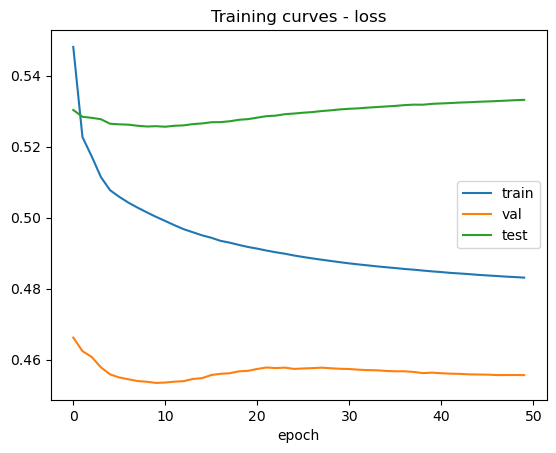

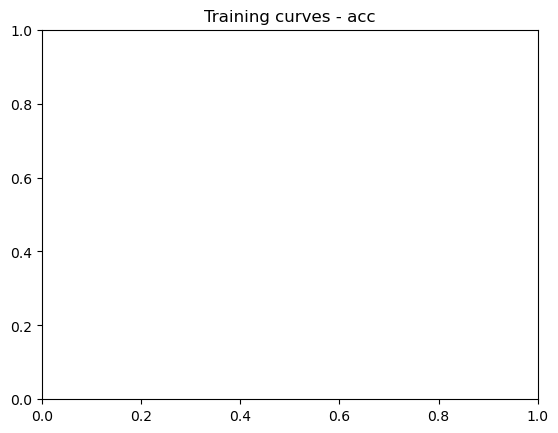

In [14]:
plot_training_curves(training_curves_three_layer, phases=['train', 'val', 'test'])

En este gráfico, vemos que el modelo se está sobreajustando al conjunto de entrenamiento. A medida que la curva de entrenamiento, en azul, disminuye de forma constante, la pérdida en la validación aumenta. En las siguientes secciones, abordaremos el problema del sobreajuste.


At default threshold:
 TN =   258,  FP =   143 -> N =   401
 FN =    86,  TP =   348 -> P =   434
TNR = 0.643, FPR = 0.357
FNR = 0.198, TPR = 0.802
ACC =  0.726


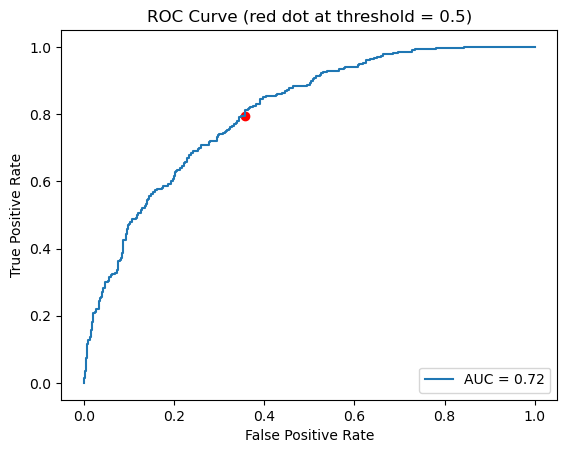

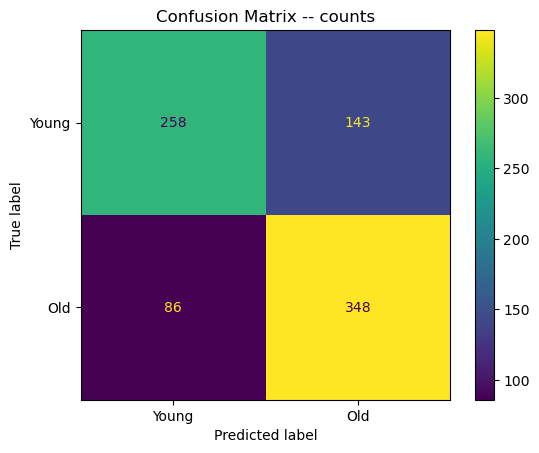

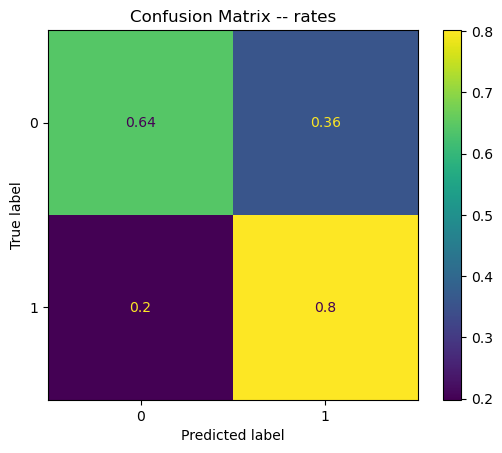

In [15]:
res = plot_metrics(three_layer_model, device, dataloaders, phase='test')

Aquí vemos la curva ROC y la matriz de confusión de las que hemos hablado en el módulo. Parece que el modelo está clasificando incorrectamente a los abalones jóvenes como viejos en mayor proporción que al revés.

## Atributos adicionales


En la primera ronda de selección de atributos, hemos elegido solo atributos numéricos. Sin embargo, al no incluir el sexo de los abalones en el modelo, estamos perdiendo información fundamental. Para trasladar este atributo ternario desde el conjunto de datos al modelo, utilizaremos una técnica llamada codificación *one-hot*. Vamos a crear un atributo para cada una de las opciones y asignaremos un valor de 1 si la muestra pertenece a esa clase y de 0 si no pertenece. Las estrategias de codificación pueden ser tan sencillas como este método o mucho más complejas, como veremos en los próximos módulos.

In [16]:
# Insertar los nuevos atributos mediante codificación one-hot
encoded_df = df.copy(True)
encoded_df.insert(1, 'M', 0)
encoded_df.insert(1, 'F', 0)
encoded_df.insert(1, 'I', 0)
encoded_df.loc[(df['Sex'] == 'M'), 'M'] = 1
encoded_df.loc[(df['Sex'] == 'F'), 'F'] = 1
encoded_df.loc[(df['Sex'] == 'I'), 'I'] = 1
encoded_column_names = column_names[:]
encoded_column_names.insert(1,"M")
encoded_column_names.insert(1,"F")
encoded_column_names.insert(1,"I")
encoded_df.head()

,Sex,I,F,M,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weights,Rings,Old
0,M,0,0,1,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,1
1,M,0,0,1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0
2,F,0,1,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,0
3,M,0,0,1,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,1
4,I,1,0,0,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0


In [17]:
encoded_feature_columns = encoded_column_names[1:8]
print(encoded_feature_columns)
label_column = 'Old'

df.head()

['I', 'F', 'M', 'Length', 'Diameter', 'Height', 'Whole weight']


,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weights,Rings,Old
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,1
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,0
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,1
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0


### División entrenamiento/validación/prueba y estandarización

Una vez más, queremos realizar una división entrenamiento/validación/prueba en el conjunto de datos. Sin embargo, debemos asegurarnos de no estandarizar los nuevos atributos añadidos mediante codificación *one-hot*.

In [18]:
# Aquí, utilizaremos ColumnTransformer para volver a realizar una estandarización de los datos. Sin embargo, solo queremos que se aplique a los atributos numéricos, 
# NO a los codificados mediante one-hot, así que lo especificaremos en el constructor de ColumnTransformer.
ct = ColumnTransformer([('numerical_features', StandardScaler(), numerical_feature_columns)], remainder='passthrough')

encoded_train_dataset, encoded_test_dataset, encoded_val_dataset = train_test_val_split(encoded_df, encoded_feature_columns, label_column, ct)

### Hiperparámetros del modelo

In [19]:
# Configuración del dispositivo (si es posible, entrenar el modelo en la GPU, el proceso será mucho más rápido)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hiperparámetros

input_size = len(encoded_feature_columns) # Asegurarse de que el tamaño del input incluya los nuevos atributos
hidden_size1 = 64
hidden_size2 = 64
hidden_size3 = 64
num_classes = 2

# Parámetros de entrenamiento externos
batch_size = 10
learning_rate = 0.001
num_epochs = 50


In [20]:
three_layer_encoded_model = SimpleClassifier3Layer(input_size, hidden_size1, hidden_size2, hidden_size3, num_classes).to(device)
print(three_layer_encoded_model)

SimpleClassifier3Layer(
  (layers): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)


### Preparación de los datos finales

In [21]:
# Configurar Datasets y DataLoaders de PyTorch

dataloaders = {'train': DataLoader(encoded_train_dataset, batch_size=batch_size),
               'val': DataLoader(encoded_val_dataset, batch_size=batch_size),
               'test': DataLoader(encoded_test_dataset, batch_size=batch_size)}

dataset_sizes = {'train': len(encoded_train_dataset),
                 'val': len(encoded_val_dataset),
                 'test': len(encoded_test_dataset)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 2506, 'val': 836, 'test': 835}


In [22]:
# Pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(three_layer_encoded_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

three_layer_encoded_model, training_curves_three_layer_encoded = train_model(three_layer_encoded_model, dataloaders, dataset_sizes, 
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/50
----------
train Loss: 0.5350 Acc: 0.7350
val   Loss: 0.4486 Acc: 0.7835
test  Loss: 0.5129 Acc: 0.7305

Epoch 2/50
----------
train Loss: 0.5075 Acc: 0.7474
val   Loss: 0.4440 Acc: 0.7871
test  Loss: 0.5069 Acc: 0.7353

Epoch 3/50
----------
train Loss: 0.5022 Acc: 0.7502
val   Loss: 0.4435 Acc: 0.7895
test  Loss: 0.5053 Acc: 0.7329

Epoch 4/50
----------
train Loss: 0.4984 Acc: 0.7458
val   Loss: 0.4434 Acc: 0.7919
test  Loss: 0.5049 Acc: 0.7257

Epoch 5/50
----------
train Loss: 0.4945 Acc: 0.7454
val   Loss: 0.4424 Acc: 0.7811
test  Loss: 0.5046 Acc: 0.7257

Epoch 6/50
----------
train Loss: 0.4914 Acc: 0.7478
val   Loss: 0.4409 Acc: 0.7835
test  Loss: 0.5043 Acc: 0.7246

Epoch 7/50
----------
train Loss: 0.4896 Acc: 0.7466
val   Loss: 0.4401 Acc: 0.7835
test  Loss: 0.5044 Acc: 0.7234

Epoch 8/50
----------
train Loss: 0.4879 Acc: 0.7482
val   Loss: 0.4391 Acc: 0.7907
test  Loss: 0.5047 Acc: 0.7234

Epoch 9/50
----------
train Loss: 0.4864 Acc: 0.7498
val   Loss: 0.4387

Observamos pocos cambios en el rendimiento general al incluir estos atributos, lo que nos indica que no aportan una ganancia significativa de información.

### Curvas de entrenamiento y métricas

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

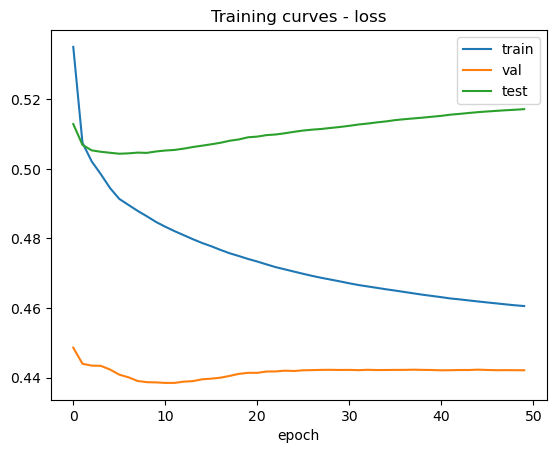

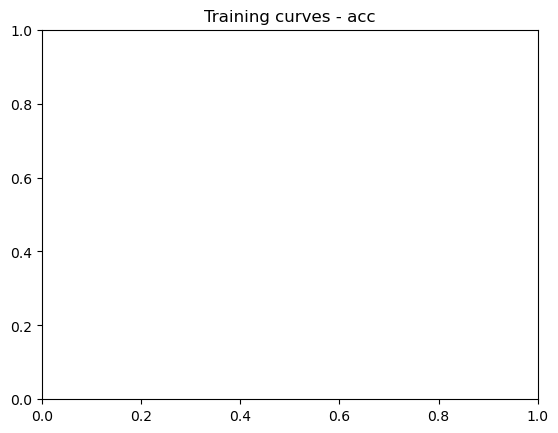

In [23]:
plot_training_curves(training_curves_three_layer_encoded, phases=['train', 'val', 'test'])

Estos gráficos nos indican también que el modelo se sigue sobreajustando al conjunto de datos.

In [ ]:
res = plot_metrics(three_layer_encoded_model, device, dataloaders, phase='test')

## Regularización y *dropout*

Una de las cuestiones clave de las que hemos hablado en este módulo son los métodos para evitar el sobreajuste. Los gráficos de arriba nos indican que el modelo se está sobreajustando considerablemente al conjunto de datos de entrenamiento, pero contamos con varias herramientas para combatir este problema.

PyTorch incluye dos de los métodos que hemos explorado, la regularización y el *dropout*. Veamos el efecto que tiene cada uno en el rendimiento del modelo.

### Regularización

In [ ]:
# Reiniciar el modelo
three_layer_encoded_l2_model = SimpleClassifier3Layer(input_size, hidden_size1, hidden_size2, hidden_size3,
                         num_classes).to(device)
print(three_layer_encoded_l2_model)

In [ ]:
# Pérdida y optimizador
criterion = nn.CrossEntropyLoss()
# Al añadir el término weight_decay al optimizador, incluímos la regularización L2
optimizer = torch.optim.Adam(three_layer_encoded_l2_model.parameters(), lr=learning_rate, weight_decay=0.01) 
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

three_layer_encoded_l2_model, training_curves_three_layer_encoded_l2 = train_model(three_layer_encoded_l2_model, dataloaders, dataset_sizes, 
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)

#### Curvas de entrenamiento y métricas

In [ ]:
plot_training_curves(training_curves_three_layer_encoded_l2, phases=['train', 'val', 'test'])

En estos gráficos, ya no observamos el mismo sobreajuste al conjunto de validación, pero podemos seguir aplicando otros métodos para mejorar más la generalización.

In [ ]:
res = plot_metrics(three_layer_encoded_l2_model, device, dataloaders, phase='test')

### *Dropout*

In [ ]:
# Configuración del dispositivo (si es posible, entrenar el modelo en la GPU, el proceso será mucho más rápido)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hiperparámetros

# Arquitectura del modelo
input_size = len(encoded_feature_columns)
hidden_size1 = 64
hidden_size2 = 64
hidden_size3 = 64
num_classes = 2
dropout = .25

# Parámetros de entrenamiento externos
batch_size = 10
learning_rate = 0.001
num_epochs = 50

In [ ]:
# Modelo de clasificación simple de tres capas ocultas con dropout
class SimpleClassifier3LayerDropout(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, num_classes, dropout):
        super(SimpleClassifier3LayerDropout, self).__init__()
        self.dropout = nn.Dropout(dropout) # dropout rate
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            self.dropout,
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            self.dropout,
            nn.Linear(hidden_size2, hidden_size3),
            nn.ReLU(),
            self.dropout,
            nn.Linear(hidden_size3, num_classes),
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
# Reiniciar el modelo con dropout
three_layer_encoded_l2_dropout_model = SimpleClassifier3LayerDropout(input_size, hidden_size1, hidden_size2, hidden_size3, 
                         num_classes, dropout).to(device)
print(three_layer_encoded_l2_dropout_model)

In [ ]:
# Pérdida y optimizador
criterion = nn.CrossEntropyLoss()
# Al añadir el término weight_decay al optimizador, incluímos la regularización L2
optimizer = torch.optim.Adam(three_layer_encoded_l2_dropout_model.parameters(), lr=learning_rate, weight_decay=1e-2) 
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

three_layer_encoded_l2_dropout_model, training_curves_three_layer_encoded_l2_dropout = train_model(three_layer_encoded_l2_dropout_model, dataloaders, dataset_sizes, 
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)

En este caso, incluir el *dropout* ha supuesto un cambio muy pequeño en la precisión general. Teniendo en cuenta que se trata de un modelo profundo relativamente simple (sobre todo, en comparación con algunas de las redes centradas en la visión artificial que veremos más adelante), no es algo inesperado, y es posible que el *dropout* no sea la mejor solución para resolver este problema. De todos modos, echemos un vistazo a las siguientes curvas de entrenamiento.

#### Curvas de entrenamiento y métricas

In [ ]:
plot_training_curves(training_curves_three_layer_encoded_l2_dropout, phases=['train', 'val', 'test'])

En estas curvas, vemos que incluir el *dropout* ha mejorado la generalización del modelo y ha evitado el sobreajuste.

In [ ]:
res = plot_metrics(three_layer_encoded_l2_dropout_model, device, dataloaders, phase='test')

## Modelo de regresión

Ahora, en vez de hacer una clasificación binaria sobre si un abalón es joven o viejo, queremos predecir el número exacto de anillos. Adaptar el modelo para que realice esta tarea es sencillo.

### Preparación del conjunto de datos

In [ ]:
regression_label_column = 'Rings' # Solo tenemos que cambiar la columna de la etiqueta
# El número de anillos tiene que ser un float, de lo contrario la función de pérdida no funcionará
encoded_df[regression_label_column] = encoded_df[regression_label_column].astype('float32')
encoded_df.dtypes

### División entrenamiento/validación/prueba y estandarización

In [ ]:
ct = ColumnTransformer([('numerical_features', StandardScaler(), numerical_feature_columns)], remainder='passthrough')

regression_train_dataset, regression_test_dataset, regression_val_dataset = train_test_val_split(encoded_df, encoded_feature_columns, regression_label_column, ct)

### Hiperparámetros

In [ ]:
# Configuración del dispositivo (si es posible, entrenar el modelo en la GPU, el proceso será mucho más rápido)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hiperparámetros

# Arquitectura del modelo
input_size = len(encoded_feature_columns)
hidden_size1 = 64
hidden_size2 = 64
hidden_size3 = 64
output_neurons = 1
dropout = .25

# Parámetros de entrenamiento externos
batch_size = 10
learning_rate = 0.001
num_epochs = 50

In [ ]:
# Modelo de regresión simple de tres capas ocultas con dropout
class SimpleRegressor(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_neurons, dropout):
        super(SimpleRegressor, self).__init__()
        self.dropout = nn.Dropout(dropout) # dropout rate
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            self.dropout,
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            self.dropout,
            nn.Linear(hidden_size2, hidden_size3),
            nn.ReLU(),
            self.dropout,
            nn.Linear(hidden_size3, output_neurons),
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
regression_model = SimpleRegressor(input_size, hidden_size1, hidden_size2, hidden_size3, output_neurons, dropout).to(device)
print(regression_model)

### Preparación final de los datos

In [ ]:
# Configurar Datasets y DataLoaders de PyTorch

dataloaders = {'train': DataLoader(regression_train_dataset, batch_size=batch_size),
               'val': DataLoader(regression_val_dataset, batch_size=batch_size),
               'test': DataLoader(regression_test_dataset, batch_size=batch_size)}

dataset_sizes = {'train': len(regression_train_dataset),
                 'val': len(regression_val_dataset),
                 'test': len(regression_test_dataset)}
print(f'dataset_sizes = {dataset_sizes}')

### Entrenar el modelo

Ahora, vamos a aumentar el proceso de entrenamiento que utilizamos antes para adaptarlo al problema de regresión

In [ ]:
# Extraído de https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def train_regression_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    best_epoch = 0

    # Cada ciclo tiene una fase de entrenamiento, una de validación y una de prueba
    phases = ['train', 'val', 'test']
    
    # Hacer un seguimiento de la evolución de la pérdida y la precisión durante el entrenamiento
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Configurar el modelo en el modo de entrenamiento
            else:
                model.eval()   # Configurar el modelo en el modo de evaluación
            running_loss = 0.0

            # Iterar con los datos
            for inputs, targets in dataloaders[phase]: 
                inputs = inputs.to(device)
                targets = targets.to(device) #

                # Poner a 0 los gradientes de los parámetros
                optimizer.zero_grad()

                # Método forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = torch.flatten(model(inputs))
                    loss = criterion(outputs, targets)

                    # Método backward y actualización de los pesos solo si está en la fase de entrenamiento
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Estadísticas
                running_loss += loss.item() * inputs.size(0)
 
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)

            print(f'{phase:5} Loss: {epoch_loss:.4f}')

            # Hacer una copia profunda del modelo si se ha alcanzado la mejor precisión (en función de la validación)
            if phase == 'val' and epoch_loss < best_loss:
                best_epoch = epoch
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Loss: {best_loss:4f} at epoch {best_epoch}')

    # Cargar los mejores pesos del modelo
    model.load_state_dict(best_model_wts)
    
    return model, training_curves

In [ ]:
# Pérdida y optimizador
criterion = nn.MSELoss() # Pérdida del ECM en vez entropía cruzada
optimizer = torch.optim.Adam(regression_model.parameters(), lr=learning_rate, 
                             weight_decay=0.01) 
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

regression_model, training_curves_regression = train_regression_model(regression_model, dataloaders, dataset_sizes, 
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)

In [ ]:
plot_training_curves(training_curves_regression, metrics=['loss'])

In [ ]:
predicted_ages, true_ages = regress_predictions(regression_model, device, dataloaders['train'])
# Vemos que nuestras predicciones tienen bastante sentido respecto a las edades de los abalones

In [ ]:
predicted_ages

In [ ]:
true_ages 

In [ ]:
# Resultados del entrenamiento
plot_regression(regression_model, device, dataloaders['train'])

In [ ]:
# Resultados de la validación
plot_regression(regression_model, device, dataloaders['val'])

In [ ]:
# Resultados de la prueba
plot_regression(regression_model, device, dataloaders['test'])

### ¿Qué viene después?

Ahora que hemos aprendido los fundamentos de PyTorch, seremos capaces de realizar muchas tareas de *machine learning*. Empezaremos por el reconocimiento de cifras con el conjunto de datos MNIST, lo que también nos servirá para introducir arquitecturas más complejas de redes neuronales profundas.